In [1]:
# This file uses the inhouse qcbm code from the paper and compares MMD with MCR
import numpy as np
import matplotlib.pyplot as plt
import copy
import q_circuit as q # In house circuit code, to comare with Qiskit
import torch
import time
import os

# Oh Hail the almighty Qiskit:
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit.providers.jobstatus import JobStatus

# Import custom packages: These are written by me
import InHouse_Circuits as ihc
import Qiskit_Circuits as qkc
import Q_Generator as QG
import Q_Loss_and_Gradients as Q_gradients
import Utils
import Discriminator_Utils as D_utils # A file that contains different discriminator architectures

In [2]:
# IBMQ.enable_account("a66a83268fbf696a24b481c5d7568d50f14a1b2f28c6932d600a625b9cbffc6e28a6594bdd422676c9b2a214dcafa87d57012cc8678cbabaeecb319a0515f4c2")

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()

In [4]:
#backend = provider.get_backend('simulator_statevector')

In [2]:
#======================================Start of Configurations=================================
n_qubits = 6 # We use 6 qubits, two hidden
n_h_qubits = 0
n_show_qubits = n_qubits-n_h_qubits
x_basis_m_n = torch.FloatTensor(Utils.binary_basis((n_show_qubits,))) 
sigma_list = [0.5, 1]
K = Utils.mix_rbf_kernel(x_basis_m_n, x_basis_m_n, sigma_list)

geometry = (2,3) # The qubits are put on a 2 by 2 graph

#connections = q.get_nn_pairs((6,))[:-1] # The qubits are CNOT-entangled by nearest neighbors on the 2 by 2 graph
connections = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
print('connection scheme', connections)

simulator = qiskit.Aer.get_backend('statevector_simulator')

circuit0 = qkc.MBL_Circuit(delta_t=0.014, t_m=0.14, Jxy=0.0, Jzz=0.0, n_qubits=n_qubits, n_h_qubits=n_h_qubits, 
                           connections=connections, 
                           backend=simulator, shots=100, if_measure=False)

connection scheme [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


Test out the circuit

In [3]:
mags = []
J_xy_list = np.linspace(0, 2.5, 16)
for i in range(len(J_xy_list)):
    # At initialization, the circuit does not have any gates
    Jxy = -J_xy_list[i]
    circuit0.Jxy = Jxy # changing Jxy for the new m group layer
    circuit0.append_layers_m(m=i)
    
    
    prob0, prob1 = circuit0.marginal(5, torch.zeros((circuit0.current_m+1, circuit0.n_qubits)))
    mags.append(prob0-prob1)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [4]:
mags

[(0.9999999999999996+0j),
 (0.9999999994380194+0j),
 (0.999999587209262+0j),
 (0.999974013543017+0j),
 (0.9994679304163179+0j),
 (0.9944695357117213+0j),
 (0.964500928385426+0j),
 (0.8454851334175295+0j),
 (0.5246008940652918+0j),
 (-0.04668961457351406+0j),
 (-0.6518399226918729+0j),
 (-0.9212252952532554+0j),
 (-0.8657981281999649+0j),
 (-0.8198295507780315+0j),
 (-0.7712963492155356+0j),
 (-0.501688942103382+0j)]

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Aperiodic 1D, 10 trotter slices/quench')

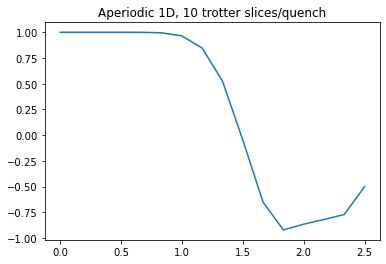

In [5]:
plt.plot(np.linspace(0, 2.5, 16),mags)
plt.title('Aperiodic 1D, 10 trotter slices/quench')

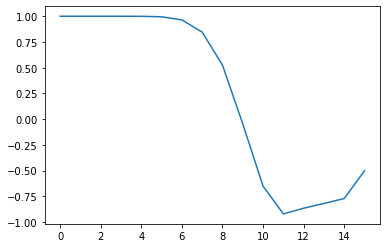

In [6]:
plt.plot(mags)